In [1]:
import os
import torch
import torch.nn as nn
from einops import rearrange
# import imageio.v3 as iio
import numpy as np
import copy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import torch.nn.functional as F
import warnings
from video_dataset import VideoFrameDataset, ImglistToTensor

In [2]:
root = '/Users/luiginoto/Downloads/Dataset_Student/train/data/'
annotation_file = '/Users/luiginoto/Downloads/Dataset_Student/train/annotations.txt'

In [3]:
root = '../Dataset/Dataset_Student/train/data/'
annotation_file = '../Dataset/Dataset_Student/train/annotations.txt'

In [2]:
root = '/train/data/'
annotation_file = '/train/annotations.txt'

In [3]:
# transform_train = transforms.Compose([
#     #transforms.RandomCrop(32, padding=4),
#     transforms.Resize((128,128)),
#     #transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        # transforms.Resize(299),  # image batch, resize smaller edge to 299
        transforms.Resize((128,128)),
        # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [4]:
dataset = VideoFrameDataset(
    root_path=root,
    annotationfile_path=annotation_file,
    num_segments=1,
    frames_per_segment=22,
    imagefile_template='image_{:d}.png',
    transform=preprocess,
    mask=True,
    test_mode=False
)

In [6]:
sample = dataset[0] 
frames = sample[0]

In [7]:
len(sample)

3

In [8]:
mask = sample[2]
mask.shape

torch.Size([22, 160, 240])

In [9]:
frames.shape

torch.Size([22, 3, 128, 128])

/tmp/ipykernel_5447/1220864285.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3053.)
  plt.imshow(torch.transpose(frames[0],1,2).T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


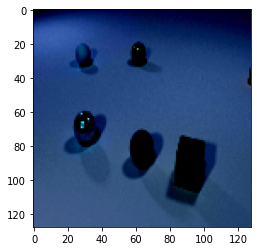

In [10]:
import matplotlib.pyplot as plt
plt.imshow(torch.transpose(frames[0],1,2).T)

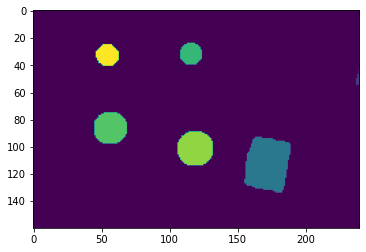

In [11]:
plt.imshow(mask[0])

In [5]:
dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=2,
        shuffle=True,
        num_workers=1,
        pin_memory=True
    )

In [35]:
dataloader

In [14]:
data, target, mask = next(iter(dataloader))

In [15]:
data.shape

torch.Size([2, 22, 3, 128, 128])

In [6]:
from models import IJEPA_base, CustomDataParallel, EarlyStop

- Get patch embed for each frame of video
- Split into context and target with: context first 11 frames, target all frames (or context first frame oatches + random subsequent patches)
- Add learnable spatial-temporal positional embedding
- Feed context and target into context encoder and target encoder
- Input 11 mask token and context representation to predictor (ViT)
- 

In [17]:
frames.shape

torch.Size([22, 3, 128, 128])

In [7]:
encoder = IJEPA_base(img_size=128, patch_size=8, in_chans=3, norm_layer=nn.LayerNorm, num_frames=22, attention_type='divided_space_time', dropout=0.1, mode="test", M=4, embed_dim=384,
                        # encoder parameters
                        enc_depth=10,
                        enc_num_heads=6,
                        enc_mlp_ratio=4.,
                        enc_qkv_bias=False,
                        enc_qk_scale=None,
                        enc_drop_rate=0.,
                        enc_attn_drop_rate=0.,
                        enc_drop_path_rate=0.1,
                        # predictor parameters
                        pred_depth=10,
                        pred_num_heads=6,
                        pred_mlp_ratio=4.,
                        pred_qkv_bias=False,
                        pred_qk_scale=None,
                        pred_drop_rate=0.1,
                        pred_attn_drop_rate=0.1,
                        pred_drop_path_rate=0.1,
                        # positional and spacial embedding parameters
                        pos_drop_rate=0.1,
                        time_drop_rate=0.1)

In [20]:
from decoders import ATMHead
from atm_loss import ATMLoss

In [21]:
decoder = ATMHead(img_size=128, H=160, W=240, in_channels=384, use_stages=1)
criterion = ATMLoss(48, 1)

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
path_best = os.path.join("/scratch/gb2572/DL_project_2023/output/test_2", "models/best")
if os.path.exists(path_best):
    checkpoint = torch.load(os.path.join(path_best, "best_model.pkl"), map_location=device)
    encoder_state_dict = checkpoint # checkpoint['model_state_dict']
    # encoder_state_dict['mode'] = 'test'
    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device)

In [24]:
path_partials = os.path.join("/scratch/gb2572/DL_project_2023/output/test_2", "models/decoder")
if os.path.exists(path_partials):
    checkpoint = torch.load(os.path.join(path_partials, "checkpoint_decoder.pkl"), map_location=device)
    decoder.load_state_dict(checkpoint['model_state_dict'])
    decoder.to(device)

In [25]:
criterion.to(device)

ATMLoss(
  (criterion): SetCriterion()
)

In [26]:
data.shape

torch.Size([2, 22, 3, 128, 128])

In [27]:
data.transpose(1, 2).shape

torch.Size([2, 3, 22, 128, 128])

In [28]:
data, target, mask = data.to(device), target.to(device), mask.to(device)

In [29]:
encoder.get_patch_embeddings(data.transpose(1, 2)[:,:,:11])

(tensor([[[-1.6091e-01, -8.6153e-02,  1.7014e-01,  ...,  2.2713e-01,
            0.0000e+00,  1.7968e-02],
          [-1.5286e-01, -9.0983e-02,  1.6552e-01,  ...,  2.2565e-01,
            2.1300e-01,  0.0000e+00],
          [-1.5270e-01,  3.3396e-03,  1.6596e-01,  ...,  2.2623e-01,
            2.1052e-01,  1.9449e-02],
          ...,
          [ 4.0612e-01, -4.2820e-02, -3.6326e-01,  ..., -2.3475e-01,
            3.4676e-01,  0.0000e+00],
          [-6.7696e-01,  2.7140e-01,  0.0000e+00,  ...,  5.3801e-01,
           -0.0000e+00, -0.0000e+00],
          [ 7.4813e-05, -8.0530e-02,  7.3920e-02,  ..., -1.1399e-02,
            2.4331e-01,  1.5057e-01]],
 
         [[-1.5381e-01, -9.1332e-02,  1.6578e-01,  ...,  2.2356e-01,
            2.1173e-01, -4.9918e-03],
          [ 5.1353e-03, -9.0848e-02,  1.6591e-01,  ...,  1.3685e-03,
            2.1262e-01,  1.4709e-02],
          [-1.5276e-01, -9.0097e-02,  1.6664e-01,  ...,  2.2389e-01,
            2.1211e-01, -4.7951e-03],
          ...,
    

In [10]:
torch.cuda.empty_cache()

In [31]:
pred = encoder(data.transpose(1, 2)[:,:,:11])

In [32]:
pred.shape

torch.Size([2, 22, 256, 384])

In [10]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from typing import Optional
import math
from functools import partial

In [34]:
pred = rearrange(pred, 'b t n m -> (b t) n m')
pred.shape

torch.Size([44, 256, 384])

In [35]:
mask = rearrange(mask, 'b t n m -> (b t) n m')
mask.shape

torch.Size([44, 160, 240])

In [36]:
output = decoder(pred)

In [37]:
len(output)

4

In [38]:
output['pred'].shape

torch.Size([44, 48, 160, 240])

In [39]:
torch.argmax(output['pred'], 1).shape

torch.Size([44, 160, 240])

In [40]:
pred[0]

tensor([[-0.0249,  0.0787,  0.3657,  ...,  0.1183, -0.7806,  1.1365],
        [-0.0326,  0.0875,  0.3664,  ...,  0.1237, -0.7781,  1.1259],
        [-0.0262,  0.0890,  0.3675,  ...,  0.1139, -0.7813,  1.1372],
        ...,
        [ 0.0656,  0.0677,  0.2407,  ..., -0.0108, -0.7029,  1.1393],
        [ 0.0638,  0.0715,  0.2427,  ...,  0.0028, -0.7027,  1.1379],
        [ 0.0649,  0.0672,  0.2394,  ..., -0.0018, -0.7005,  1.1414]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [41]:
pred[21]

tensor([[-0.0292,  0.0886,  0.3610,  ...,  0.1147, -0.7755,  1.1373],
        [-0.0309,  0.0853,  0.3722,  ...,  0.1172, -0.7891,  1.1461],
        [-0.0246,  0.0851,  0.3629,  ...,  0.1139, -0.7786,  1.1326],
        ...,
        [ 0.0921,  0.0749,  0.2446,  ...,  0.0029, -0.7003,  1.1463],
        [ 0.0766,  0.0680,  0.2447,  ..., -0.0057, -0.7016,  1.1473],
        [ 0.0763,  0.0647,  0.2358,  ..., -0.0067, -0.6931,  1.1511]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [42]:
output['pred_masks'][0]

tensor([[[ 0.6375,  0.6375,  0.6375,  ...,  0.6386,  0.6386,  0.6386],
         [ 0.6375,  0.6375,  0.6375,  ...,  0.6386,  0.6386,  0.6386],
         [ 0.6375,  0.6375,  0.6375,  ...,  0.6386,  0.6386,  0.6386],
         ...,
         [ 0.7085,  0.7085,  0.7085,  ...,  0.7119,  0.7119,  0.7119],
         [ 0.7085,  0.7085,  0.7085,  ...,  0.7119,  0.7119,  0.7119],
         [ 0.7085,  0.7085,  0.7085,  ...,  0.7119,  0.7119,  0.7119]],

        [[-1.9450, -1.9450, -1.9450,  ..., -1.9465, -1.9465, -1.9465],
         [-1.9450, -1.9450, -1.9450,  ..., -1.9465, -1.9465, -1.9465],
         [-1.9450, -1.9450, -1.9450,  ..., -1.9465, -1.9465, -1.9465],
         ...,
         [-2.0503, -2.0503, -2.0503,  ..., -2.0554, -2.0554, -2.0554],
         [-2.0503, -2.0503, -2.0503,  ..., -2.0554, -2.0554, -2.0554],
         [-2.0503, -2.0503, -2.0503,  ..., -2.0554, -2.0554, -2.0554]],

        [[-1.9500, -1.9500, -1.9500,  ..., -1.9517, -1.9517, -1.9517],
         [-1.9500, -1.9500, -1.9500,  ..., -1

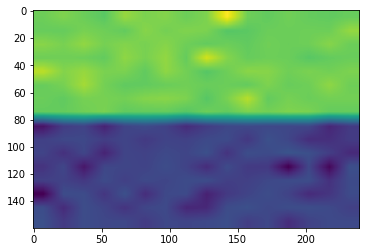

In [43]:
plt.imshow(output['pred'].cpu().detach().numpy()[0, 30])

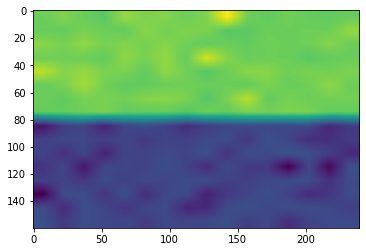

In [44]:
plt.imshow(output['pred'].cpu().detach().numpy()[0, 5])

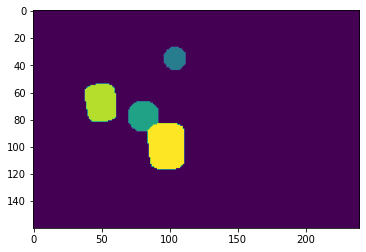

In [45]:
plt.imshow(mask[21].cpu())

In [46]:
mask[21].unique()

tensor([ 0., 19., 26., 40., 45.], device='cuda:0')

In [47]:
torch.argmax(output['pred_masks'], 1)[40].unique()

tensor([0], device='cuda:0')

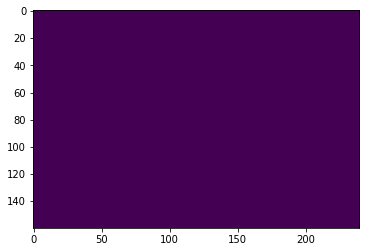

In [48]:
plt.imshow(torch.argmax(output['pred_masks'], 1).cpu().detach().numpy()[0])

In [49]:
output['pred_logits'].shape

torch.Size([44, 49, 49])

In [50]:
torch.argmax(output['pred'], 1)[4]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [47]:
output['pred_logits'].shape

torch.Size([44, 49, 49])

In [78]:
output['pred_masks'].shape

torch.Size([44, 49, 160, 240])

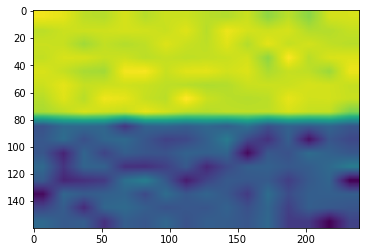

In [95]:
plt.imshow(output['pred_masks'].detach().numpy()[0, 0])

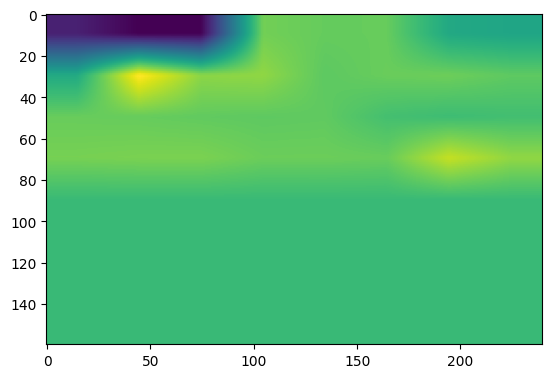

In [81]:
plt.imshow(output['pred_masks'].detach().numpy()[0, 0])

In [11]:
from decoders import DecoderSimple

In [12]:
decoder_simple = DecoderSimple(384, 49, 256, 160, 240)

In [13]:
decoder_simple.to(device)

DecoderSimple(
  (deconv1): ConvTranspose2d(384, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(64, 49, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [14]:
num_epochs = 10
total_steps = num_epochs * len(dataloader)

# should these also come from global config?
div_factor = 5 # max_lr/div_factor = initial lr
final_div_factor = 10 # final lr is initial_lr/final_div_factor 
patience = 10

# Used this approach so that we can getv back to training the loaded model from checkpoint
epoch = 0

In [15]:
optimizer = torch.optim.AdamW(decoder_simple.parameters(), lr=0.001, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0.000001)

In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
while epoch < num_epochs:
    decoder_simple.train()
    # do we need to do encoder.eval() or something? Since we are not training it, we want to deactivate the dropouts
    train_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, labels, target_masks = data 
        inputs, labels, target_masks = inputs.to(device), labels.to(device), target_masks.to(device)

        inputs = inputs[:, :11]

        optimizer.zero_grad()

        ### forward pass through encoder to get the embeddings
        predicted_embeddings = encoder(inputs.transpose(1, 2))

        # Reshape predicted embeddings to (b t) (h w) m
        predicted_embeddings = rearrange(predicted_embeddings, 'b t n m -> (b t) n m')
        target_masks = rearrange(target_masks, 'b t h w -> (b t) h w')

        ### forward pass through decoder to get the masks
        outputs = decoder_simple(predicted_embeddings)

        ### compute the loss and step
        loss = criterion(outputs, target_masks.long())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update the scheduler learning rate
        scheduler.step()

    avg_epoch_loss = train_loss / len(dataloader)
    print(f'Epoch {epoch}, epoch loss : {avg_epoch_loss}')
    epoch += 1

Epoch 0, epoch loss : 0.4506720202565193
Epoch 1, epoch loss : 0.38976172703504564
Epoch 2, epoch loss : 0.38958920392394064
Epoch 3, epoch loss : 0.38903216215968134
Epoch 4, epoch loss : 0.3885175822675228
Epoch 5, epoch loss : 0.38800394752621653
Epoch 6, epoch loss : 0.3875126749575138
Epoch 7, epoch loss : 0.3869595964550972
Epoch 8, epoch loss : 0.386551709830761
Epoch 9, epoch loss : 0.3861773359775543


In [18]:
root_val = '/val/data/'
annotation_file_val = '/val/annotations.txt'

datasetval = VideoFrameDataset(
    root_path=root_val,
    annotationfile_path=annotation_file_val,
    num_segments=1,
    frames_per_segment=22,
    imagefile_template='image_{:d}.png',
    transform=preprocess,
    mask=True,
    test_mode=False
)

dataloader_val = torch.utils.data.DataLoader(
        dataset=datasetval,
        batch_size=2,
        shuffle=True,
        num_workers=1,
        pin_memory=True
    )

In [22]:
data, target, mask = next(iter(dataloader_val))
data, target, mask = data.to(device), target.to(device), mask.to(device)

In [23]:
pred = encoder(data.transpose(1, 2)[:,:,:11])

In [24]:
pred = rearrange(pred, 'b t n m -> (b t) n m')
pred.shape

torch.Size([44, 256, 384])

In [25]:
mask = rearrange(mask, 'b t n m -> (b t) n m')
mask.shape

torch.Size([44, 160, 240])

In [26]:
output = decoder_simple(pred)

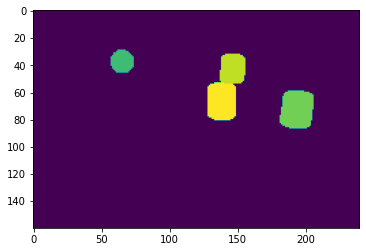

In [27]:
plt.imshow(mask[21].cpu())

In [30]:
output

tensor([[[[ 3.7663,  5.3039,  5.1208,  ...,  5.2952,  5.3189,  3.8562],
          [ 5.5619,  6.5473,  6.5038,  ...,  6.2919,  6.5529,  5.7733],
          [ 4.9007,  5.1057,  5.1590,  ...,  4.9068,  4.9522,  5.2770],
          ...,
          [ 5.0564,  5.0692,  5.0144,  ...,  4.8979,  5.0206,  5.1689],
          [ 5.2280,  5.8477,  5.8246,  ...,  6.0348,  6.0465,  5.4929],
          [ 4.0970,  5.3776,  5.4205,  ...,  5.4968,  5.4616,  4.1775]],

         [[-2.2925, -3.7958, -3.5086,  ..., -4.0032, -3.7358, -2.4098],
          [-3.2704, -4.9369, -4.6652,  ..., -4.7607, -4.6641, -3.4301],
          [-2.9881, -4.0963, -3.8952,  ..., -3.7264, -3.8390, -3.1981],
          ...,
          [-3.0802, -3.9477, -3.7901,  ..., -3.7456, -3.8852, -3.1145],
          [-3.2335, -4.4056, -4.2238,  ..., -4.3600, -4.6724, -3.0369],
          [-2.4575, -4.0566, -3.7121,  ..., -3.8861, -3.8137, -2.4969]],

         [[-2.3563, -3.5646, -3.4411,  ..., -3.6820, -3.7278, -2.4666],
          [-3.4578, -4.9954, -

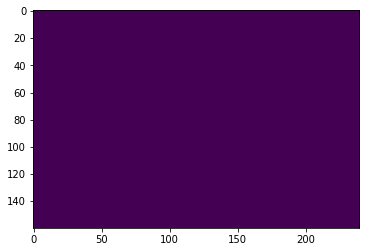

In [29]:
plt.imshow(torch.argmax(output, 1).cpu().detach().numpy()[0])